## Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize

from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable

from pprint import pprint
from ipdb import set_trace as brpt

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [5]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
# print(sys.path)



Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [6]:
# from src.data.datasets.maptiles import Maptiles, MapStyles
# from src.data.datamodules.mnist_datamodule import MNISTDataModule
# from src.data.datamodules.maptiles_datamodule import MaptilesDataModule
from src.data.datamodules.multisource_maptiles_datamodule import MultiMaptilesDataModule


# from src.models.plmodules.three_fcs import ThreeFCs
# from src.models.plmodules.vanilla_vae import VanillaVAE
# from src.models.plmodules.beta_vae import BetaVAE
from src.models.plmodules.bilatent_vae import BiVAE

from src.visualize.utils import show_timgs
from src.utils.misc import info, get_next_version_path, n_iter_per_epoch


## Start experiment 
Given a maptile, predict its style as one of OSM, CartoVoyager

In [7]:
# # Instantiate MNIST Datamodule
# in_shape = (1,32,32)
# batch_size = 32
# dm = MNISTDataModule(data_root=ROOT/'data', 
#                        in_shape=in_shape,
#                       batch_size=batch_size)
# dm.setup('fit')
# print("DM: ", dm.name)

In [8]:
# Instantiate Multisource Maptiles DataModule
all_cities = ['la', 'charlotte', 'vegas', 'boston', 'paris', \
              'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', \
             'berlin', 'montreal', 'rome']

data_root = Path("/data/hayley-old/maptiles_v2/")
cities = all_cities # ['berlin', 'rome', 'la', 'amsterdam', 'seoul'] #['paris']
styles = ['StamenTonerBackground'] #'OSMDefault', 'CartoVoyagerNoLabels']#'StamenWatercolor']#, 'StamenTonerLines']
zooms = ['14']
in_shape = (1, 128, 128)
batch_size = 32
print('cities: ', cities)
print('styes: ', styles)
dm = MultiMaptilesDataModule(
    data_root=data_root,
    cities=cities,
    styles=styles,
    zooms=zooms,
    in_shape=in_shape,
    batch_size=batch_size,
)
dm.setup('fit')

cities:  ['la', 'charlotte', 'vegas', 'boston', 'paris', 'amsterdam', 'shanghai', 'seoul', 'chicago', 'manhattan', 'berlin', 'montreal', 'rome']
styes:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
n_train, n_val:  3941 1688
train channelwise_mean,std:  [0.86546504] [0.32686168]


train size:  3941
shape:  torch.Size([32, 1, 128, 128])
dtype:  torch.float32
min, max:  -2.647802 0.41129017
['8754-6101', '4832-5849', '13702-6697', '13741-6707', '8803-5385', '8802-5380', '8753-6079', '13705-6714', '8762-6083', '13723-6683', '13971-6337', '13720-6684', '2798-6542', '8755-6097', '13698-6712', '4826-6151', '13717-6707', '4199-6084', '4193-6100', '13712-6692', '8418-5384', '8768-6096', '13702-6712', '8814-5373', '13707-6702', '4506-6473', '13729-6690', '13735-6706', '8758-6101', '13725-6680', '13728-6689', '13699-6713']
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


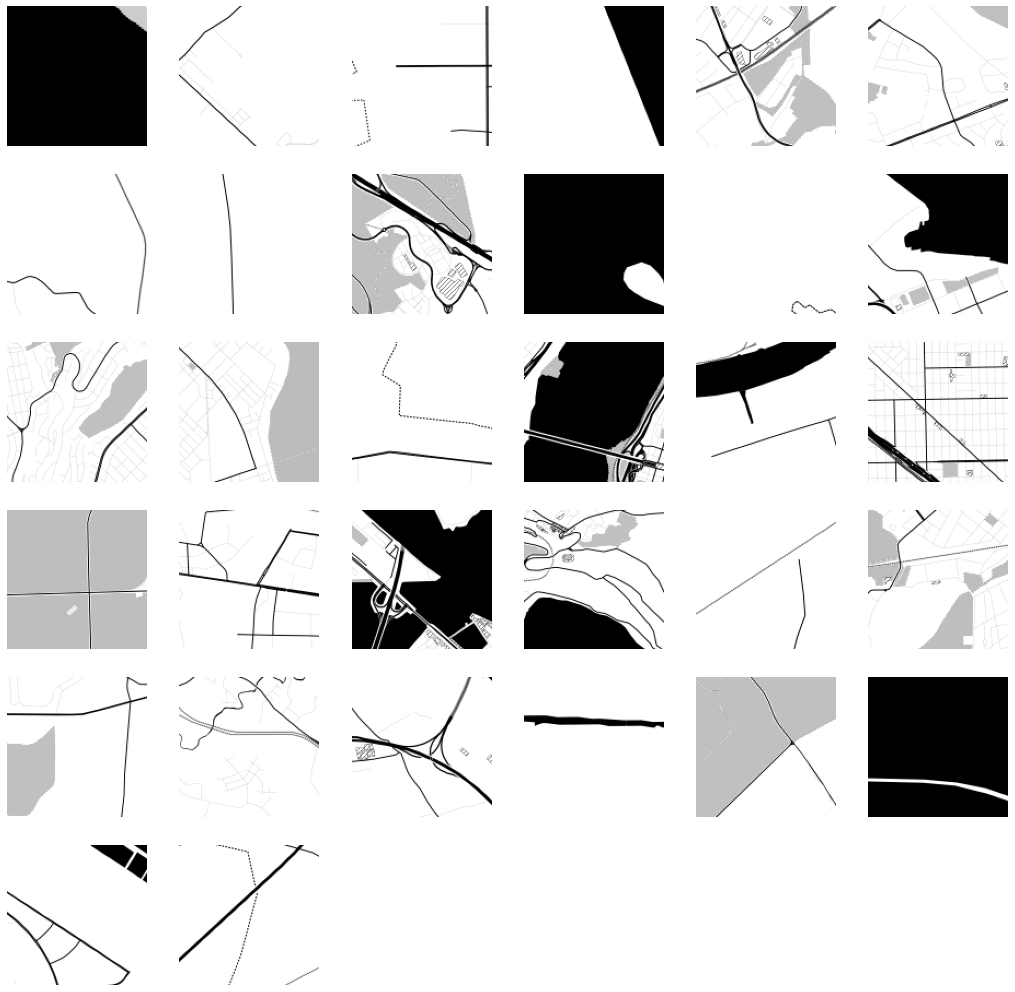

In [9]:
print('train size: ', len(dm.train_ds))
# show a batch
dl = dm.train_dataloader()
batch = next(iter(dl))
x, label_c, label_s = dm.unpack(batch)
info(x)
show_timgs(x, cmap='gray' if in_shape[0]==1 else None)
print(label_c)
print(label_s)

In [10]:
# Instantiate the pl Module
from src.models.plmodules.bilatent_vae import BiVAE

# betas = [0.1 * 3**i for i in range(10)]
# for kld_weight in [1.0]
n_styles = len(styles)
latent_dim = 10
hidden_dims = [32, 64, 128, 256] #,512]
adversary_dims = [100,100,100]
act_fn = nn.LeakyReLU()
learning_rate = 3e-4

is_contrasive = True
kld_weight = 1.0 # vae_loss = recon_loss + kld_weight * kld_weight; betas[0];
adv_loss_weight = 15. # loss = vae_loss + adv_loss_weight * adv_loss

enc_type = 'resnet'
dec_type = 'conv'
# dec_type = 'resnet'

if enc_type == 'resnet':
    hidden_dims = [32, 32, 64, 128, 256]

model = BiVAE(
    in_shape=in_shape, 
    n_styles=n_styles,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    adversary_dims=adversary_dims,
    learning_rate=learning_rate,
    act_fn=act_fn,
    is_contrasive=is_contrasive,
    kld_weight=kld_weight,
    adv_loss_weight=adv_loss_weight,
    enc_type=enc_type,
    dec_type=dec_type,
)


In [11]:
model.name

'BiVAE-C-resnet-conv-1.0-15.0'

In [12]:
# Instantiate a PL `Trainer` object
# Start the experiment
max_epochs = 200
exp_name = f'{model.name}_{dm.name}'
tb_logger = pl_loggers.TensorBoardLogger(save_dir=f'{ROOT}/temp-logs', 
                                         name=exp_name,
                                         log_graph=False,
                                        default_hp_metric=False)
print("Log dir: ", tb_logger.log_dir)

log_dir = Path(tb_logger.log_dir)
if not log_dir.exists():
    log_dir.mkdir(parents=True)
    print("Created: ", log_dir)
    

# Log computational graph
# model_wrapper = ModelWrapper(model)
# tb_logger.experiment.add_graph(model_wrapper, model.example_input_array.to(model.device))
# tb_logger.log_graph(model)

trainer_config = {
    'gpus':1,
    'max_epochs': max_epochs,
    'progress_bar_refresh_rate':0,
    'terminate_on_nan':True,
    'check_val_every_n_epoch':10,
    'logger':tb_logger,
#     'callbacks':callbacks,
}

Log dir:  /data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C-resnet-conv-1.0-15.0_Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_StamenTonerBackground_14/version_1
Created:  /data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C-resnet-conv-1.0-15.0_Maptiles_la-charlotte-vegas-boston-paris-amsterdam-shanghai-seoul-chicago-manhattan-berlin-montreal-rome_StamenTonerBackground_14/version_1


In [13]:
# trainer = pl.Trainer(fast_dev_run=3)
trainer = pl.Trainer(**trainer_config)
# trainer.tune(model=model, datamodule=dm)

# Fit model
trainer.fit(model, dm)
print(f"Finished at ep {trainer.current_epoch, trainer.batch_idx}")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
/home/hayley/miniconda3/envs/test/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)

   | Name               | Type       | Params
---------------------------------------------------
0  | act_fn             | LeakyReLU  | 0     
1  | out_fn             | Tanh       | 0     
2  | encoder            | ResNet     | 2.8 M 
3  | fc_flatten2qparams | Linear     | 327 K 
4  | fc_latent2flatten  | Linear     | 180 K 
5  | decoder            | Sequential | 388 K 
6  | out_layer          | Sequential | 10    
7  | adversary          | Sequential | 20.9 K
8  | train_style_acc    | Accuracy   | 0     
9  | val_style_acc      | Accuracy   | 0     
10 | test_style_acc     | Accuracy   | 0     
---------------------------------------------------
3.7 M     Tra

Ep: 0, batch: 0
Ep: 0, batch: 0


/home/hayley/miniconda3/envs/test/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Ep: 0, batch: 0
Ep: 10, batch: 0
Ep: 20, batch: 0
Ep: 30, batch: 0
Ep: 40, batch: 0
Ep: 50, batch: 0
Ep: 60, batch: 0
Ep: 70, batch: 0
Ep: 80, batch: 0
Ep: 90, batch: 0
Ep: 100, batch: 0
Ep: 110, batch: 0
Epoch   111: reducing learning rate of group 0 to 3.0000e-05.
Ep: 120, batch: 0
Epoch   122: reducing learning rate of group 0 to 3.0000e-06.
Ep: 130, batch: 0
Epoch   133: reducing learning rate of group 0 to 3.0000e-07.
Ep: 140, batch: 0
Epoch   144: reducing learning rate of group 0 to 3.0000e-08.
Ep: 150, batch: 0
Epoch   155: reducing learning rate of group 0 to 3.0000e-09.
Ep: 160, batch: 0
Ep: 170, batch: 0
Ep: 180, batch: 0
Ep: 190, batch: 0
Finished at ep (199, 123)


## Log  hparmeters and `best_score` to tensorboard

In [ ]:
hparams = model.hparams.copy()
hparams.update(dm.hparams)
best_score = trainer.checkpoint_callback.best_model_score.item()
metrics = {'hparam/best_score': best_score} #todo: define a metric and use it here
pprint(hparams)
pprint(metrics)

In [ ]:
# Use pl.Logger's method "log_hyperparameters" which handles the 
# hparams' element's formats to be suitable for Tensorboard logging
# See: 
# https://sourcegraph.com/github.com/PyTorchLightning/pytorch-lightning@be3e8701cebfc59bec97d0c7717bb5e52afc665e/-/blob/pytorch_lightning/loggers/tensorboard.py#explorer:~:text=def%20log_hyperparams
best_score = trainer.checkpoint_callback.best_model_score.item()
metrics = {'hparam/best_score': best_score} #todo: define a metric and use it here
trainer.logger.log_hyperparams(hparams, metrics)

 TODO:
 OPTIMIZER
 def configure_optimizers(self):
        #TODO: ADD optimizer for discriminator
        return torch.optim.Adam(self.parameters(), lr=self.hparams.get("learning_rate"))

## TODO: 
Showing the changes in the scores based on c and scores based on s will be super intersting to see as the model learns!!!

# Evaluations

In [ ]:
from src.models.plmodules.utils import get_best_ckpt, load_model, load_best_model
from pytorch_lightning.utilities.cloud_io import load as pl_load


Load best model recorded during the training


In [ ]:
ckpt_path = get_best_ckpt(model, verbose=True)
ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
print(ckpt['epoch'])

In [ ]:
# Load bestmodel
model.load_state_dict(ckpt['state_dict'])


## Reconstruction
    
    

In [ ]:
from torch.utils.tensorboard import SummaryWriter

def show_recon(model: BiVAE, 
               tb_writer: SummaryWriter=None,
               global_step:int=0,
               unnorm:bool=True, 
               to_show:bool=True, 
               verbose:bool=False):
    model.eval()
    dm = model.trainer.datamodule
    cmap = 'gray' if dm.size()[0] ==1 else None
    train_mean, train_std = dm.train_mean, dm.train_std
    with torch.no_grad():
        for mode in ['train', 'val']:
            dl = getattr(model, f"{mode}_dataloader")()
            batch = next(iter(dl))
            
            x = batch['img']
#             label_c = batch['digit']  # digit/content label (int) -- currently not used
#             label_s = batch['color']
            x = x.to(model.device)
            x_recon = model.generate(x)
            
            # Move to cpu for visualization
            x = x.cpu()
            x_recon = x_recon.cpu()
            
            if verbose: 
                info(x, f"{mode}_x")
                info(x_recon, f"{mode}_x_recon")
                
            if unnorm:
                x_unnormed = unnormalize(x, train_mean, train_std)
                x_recon_unnormed = unnormalize(x_recon, train_mean, train_std)
                if verbose:
                    print("===After unnormalize===")
                    info(x_unnormed, f"{mode}_x_unnormed")
                    info(x_recon_unnormed, f"{mode}_x_recon_unnormed")
                    
            if to_show:
                _x = x_unnormed if unnorm else x
                _x_recon = x_recon_unnormed if unnorm else x_recon
                show_timgs(_x, title=f"Input: {mode}", cmap=cmap)
#                 show_timgs(_x_recon, title=f"Recon: {mode}", cmap=cmap)
                show_timgs(LinearRescaler()(_x_recon), title=f"Recon(linearized): {mode}", cmap=cmap)

            # Log input-recon grid to TB
            if tb_writer is not None:
                input_grid = torchvision.utils.make_grid(x_unnormed) # (C, gridh, gridw)
                recon_grid = torchvision.utils.make_grid(x_recon_unnormed) # (C, gridh, gridw)
                normed_recon_grid = torchvision.utils.make_grid(LinearRescaler()(x_recon_unnormed))
                
                grid = torch.cat([input_grid, normed_recon_grid], dim=-1) #inputs | recons
                tb_writer.add_image(f"{mode}/recons", grid, global_step=global_step)


In [ ]:
show_recon(model, tb_logger.experiment, global_step=1, verbose=True)